In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [16]:
inputs = {
    "input_1": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/100001/100001_ECG",
    "input_2": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/100002/100002_ECG",
    "input_3": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103001/103001_ECG",
    "input_4": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103002/103002_ECG",
    "input_5": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/103003/103003_ECG",
    "input_6": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/104001/104001_ECG",
    "input_7": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/105001/105001_ECG",
    "input_8": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/111001/111001_ECG",
    "input_9": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/113001/113001_ECG",
    "input_10": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/114001/114001_ECG",
    "input_11": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/115001/115001_ECG",
    "input_12": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/118001/118001_ECG",
    "input_13": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/121001/121001_ECG",
    "input_14": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/122001/122001_ECG",
    "input_15": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/123001/123001_ECG",
    "input_16": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/124001/124001_ECG",
    "input_17": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/125001/125001_ECG",
    "input_18": "/home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/126001/126001_ECG"
}


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

def load_data(path):
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0]
        ecg = ecg.flatten()
        ecg = clamp_outliers(ecg)
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def clamp_outliers(signal, max_amp=5000):
    clamped_signal = []
    for value in signal:
            clamped_signal.append(-max_amp)
        else:
            clamped_signal.append(value)
    return np.array(clamped_signal)

def high_pass_filter(signal, samp_rate, cutoff_freq=1.0):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 0.5 / samp_rate)
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def estimate_dynamic_threshold(signal, window_size=1000, perc=95):
    thresholds = []
    for i in range(0, len(signal), window_size):
        window = signal[i:i + window_size]
        threshold = np.percentile(window, perc)
        thresholds.extend([threshold] * len(window))
    return np.array(thresholds[:len(signal)])

def calculate_slope(signal):
    slope = [signal[i] - signal[i - 1] for i in range(1, len(signal))]
    return np.array(slope)

def precompute_rolling_max(signal, window_size=1000, step_size=100):
    rolling_max = []
    for i in range(0, len(signal), step_size):
        window = signal[max(0, i - window_size):i + window_size]
        rolling_max.append(max(window))
    return np.array(rolling_max)

def find_Rpeaks(signal):
    dynamic_threshold = estimate_dynamic_threshold(signal)
    rolling_max = precompute_rolling_max(signal)
    slope = calculate_slope(signal)
    peaks = []
    min_distance = int(0.2 * fields["fs"])  # minimum distance is 200ms

    for i in range(1, len(signal) - 1):
        adaptive_threshold = 0.2 * rolling_max[min(i // 100, len(rolling_max) - 1)]
        if signal[i] > adaptive_threshold and signal[i] > dynamic_threshold[i] and slope[i - 1] > 0 and slope[i] < 0:
            if not peaks or (i - peaks[-1]) > min_distance:
                peaks.append(i)
    return np.array(peaks)



def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    signal_duration = len(signal) / samp_rate
    window_duration = 15.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count
    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def smooth_bpm(bpm_values, window_size=5):
    smoothed_bpm = []
    for i in range(len(bpm_values)):
        window = bpm_values[max(0, i - window_size):i + 1]
        smoothed_bpm.append(np.mean(window)) # moving average
    return np.array(smoothed_bpm)

def plot_bpm_over_time(bpm_values, driver, window_duration=15.0):
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v závislosti na čase pro měření ' + driver)
    plt.xlabel('Čas (minuty)')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

def plot_ecg_zoomed(signal, r_peaks, samp_rate, start_time, duration=20, title="Zoomed ECG (20 Seconds)"):
    start_sample = int(start_time * samp_rate)
    end_sample = int((start_time + duration) * samp_rate)
    time = np.arange(start_sample, end_sample) / samp_rate
    
    plt.figure(figsize=(15, 6))
    plt.plot(time, signal[start_sample:end_sample], label="ECG Signal", color='b')
    
    # Mark R-peaks
    zoomed_r_peaks = [p for p in r_peaks if start_sample <= p < end_sample]
    plt.scatter(
        np.array(zoomed_r_peaks) / samp_rate, 
        signal[zoomed_r_peaks], 
        color='r', marker='o', label="R-Peaks"
    )
    
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()




Successfully loaded ECG signal from /home/aerceas/Documents/dev/PZS/data/physionet.org/files/butqdb/1.0.0/100001/100001_ECG.
Sampling Rate: 1000 Hz
Found 120607 R-peaks.


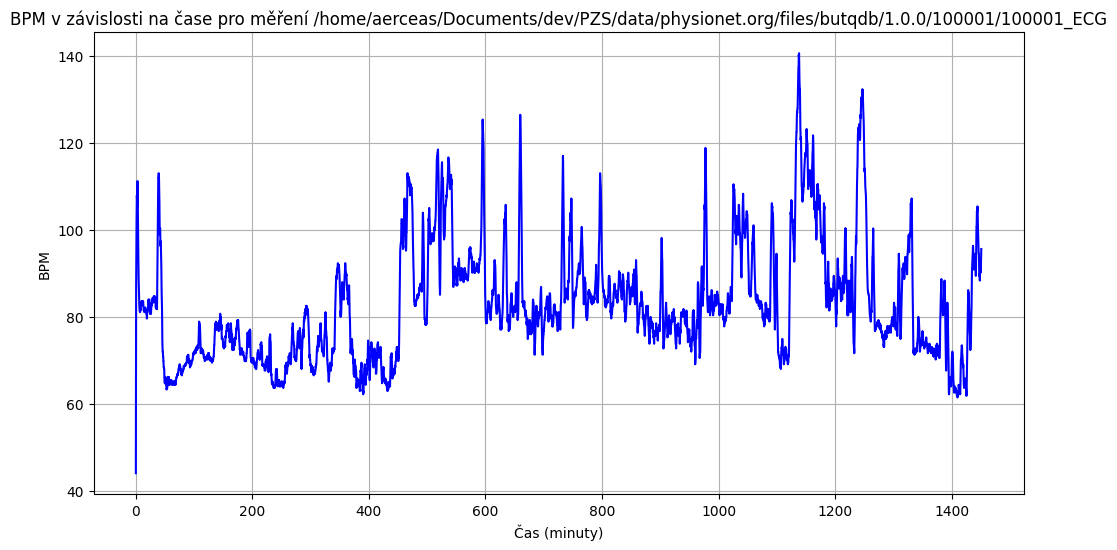

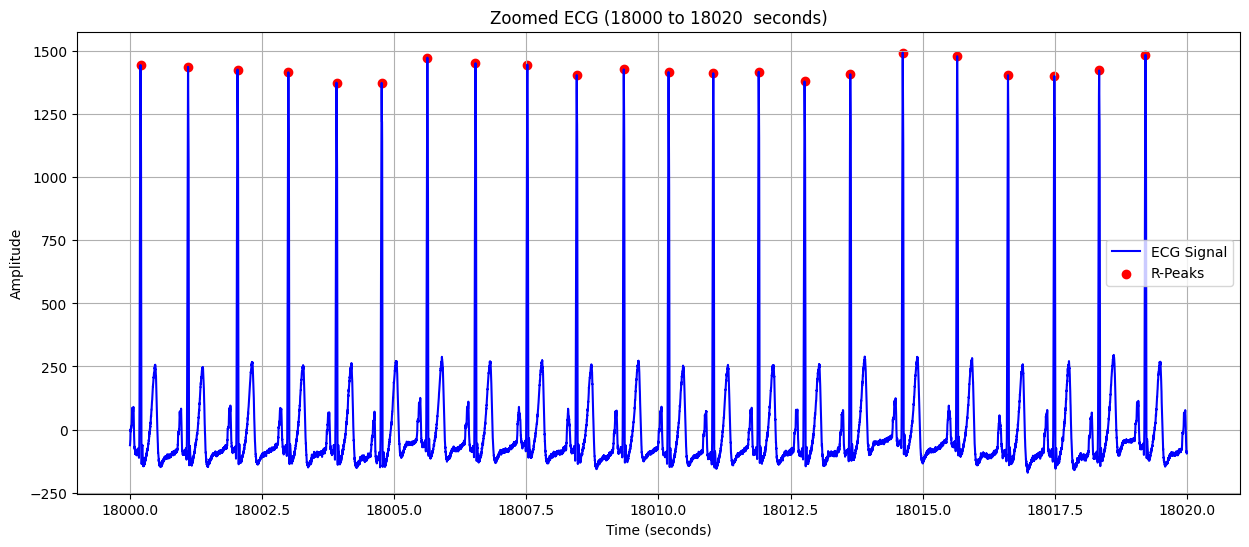

In [17]:
input_file = inputs["input_1"]

ecg_signal, fields = load_data(input_file)

if ecg_signal is not None:
    print(f"Successfully loaded ECG signal from {input_file}.")
    print(f"Sampling Rate: {fields['fs']} Hz")
    
    r_peaks = find_Rpeaks(ecg_signal)
    print(f"Found {len(r_peaks)} R-peaks.")
    
    r_peak_counts = count_rpeaks_in_windows(ecg_signal, r_peaks, fields["fs"])
    bpm_values = [count * 60 / 15 for count in r_peak_counts]  # BPM couhnt
    bpm_values = smooth_bpm(bpm_values, window_size=10) 
    plot_bpm_over_time(bpm_values, driver=f"{input_file}")
    start_time = 18000
    plot_ecg_zoomed(ecg_signal, r_peaks, fields["fs"], start_time, duration=20, title=f"Zoomed ECG ({start_time} to {start_time + 20}  seconds)")


else:
    print("Failed to load ECG data.")

In [13]:
inputs = {
    "input_1": "/home/aerceas/Documents/dev/PZS/data/mit-bih-normal-sinus-rhythm-database-1.0.0/16265",
    "input_2": "/home/aerceas/Documents/dev/PZS/data/mit-bih-normal-sinus-rhythm-database-1.0.0/17453",
}

Successfully loaded ECG signal from /home/aerceas/Documents/dev/PZS/data/mit-bih-normal-sinus-rhythm-database-1.0.0/17453.
Sampling Rate: 128 Hz
Found 112581 R-peaks.


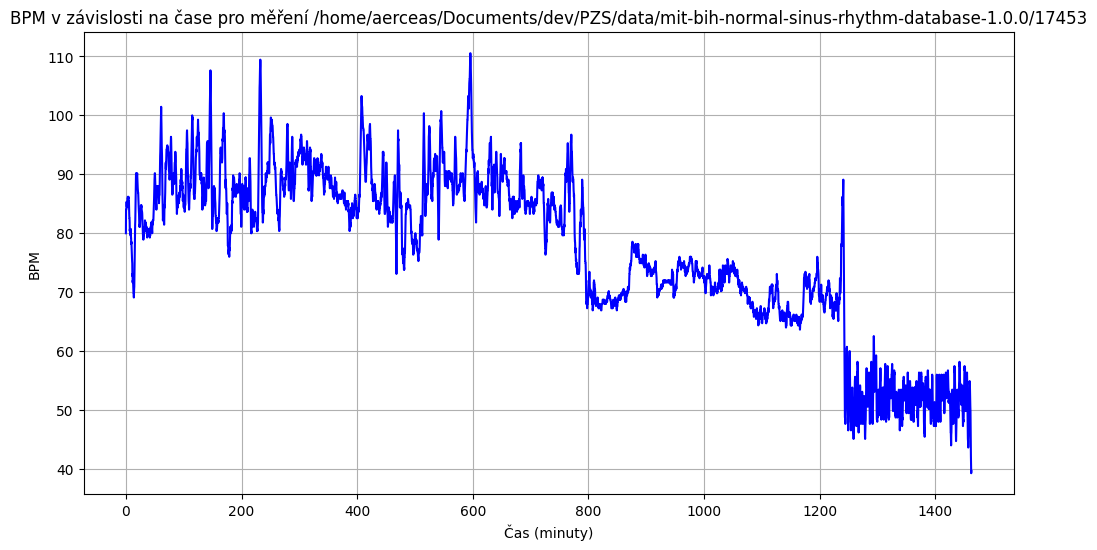

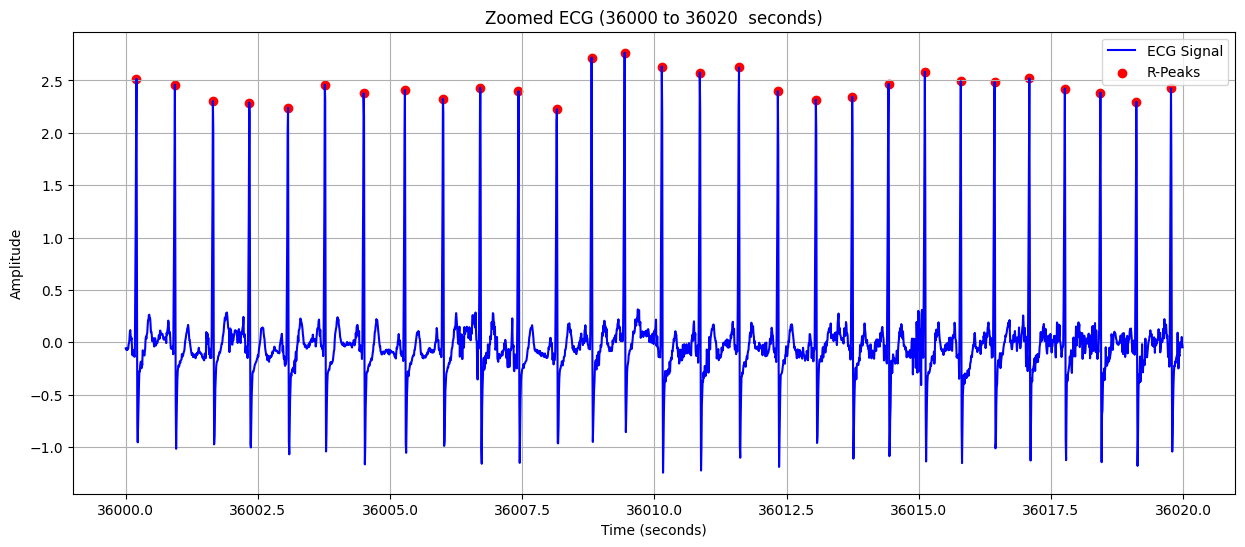

In [14]:
input_file = inputs["input_2"]

ecg_signal, fields = load_data(input_file)

if ecg_signal is not None:
    print(f"Successfully loaded ECG signal from {input_file}.")
    print(f"Sampling Rate: {fields['fs']} Hz")
    
    r_peaks = find_Rpeaks(ecg_signal)
    print(f"Found {len(r_peaks)} R-peaks.")
    
    r_peak_counts = count_rpeaks_in_windows(ecg_signal, r_peaks, fields["fs"])
    bpm_values = [count * 60 / 15 for count in r_peak_counts]  # BPM couhnt
    bpm_values = smooth_bpm(bpm_values, window_size=10) 
    plot_bpm_over_time(bpm_values, driver=f"{input_file}")
    start_time = 36000
    plot_ecg_zoomed(ecg_signal, r_peaks, fields["fs"], start_time, duration=20, title=f"Zoomed ECG ({start_time} to {start_time + 20}  seconds)")


else:
    print("Failed to load ECG data.")